In [2]:
import pickle
import torch
import pandas as pd

def read_instance(path):
    with open(path, 'rb') as handle:
        b = pickle.load(handle)
    out_df = pd.DataFrame(b['lb'].cpu()).add_prefix("output_margin_")
    diff = b['x_U'].squeeze()[:,:19].cpu() - b['x_L'].squeeze()[:,:19].cpu()
    diff_df = pd.DataFrame(diff).add_prefix("diff_")
    repetition_df = pd.DataFrame(b['rep'].cpu(), columns=["repetition"])
    pruned_df = pd.DataFrame(1 - (b['lb_plain'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_plain"])
    pruned_alpha_df = pd.DataFrame(1 - (b['lb'] <= 0).all(1).cpu().type(torch.uint8), columns=["pruned_alpha"])
    domain_df = pd.concat([out_df, diff_df, repetition_df, pruned_df, pruned_alpha_df], axis=1, join='inner')
    
    return domain_df

path = "/home/mzi/verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/take_2_alpha_alternate_90_2_10_10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"


In [2]:
# test
pdf = read_instance(path=path.format(4))
plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
print(plain_prune_ratio, alpha_gain, alpha_loss)

### prune vs repetition vs iteration

In [20]:
path = "/home/mzi/verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/take_2_alpha_alternate_90_2_10_10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"
pdf_all = read_instance(path=path.format(0))[['pruned_plain', 'pruned_alpha', 'repetition']]
pdf_all['iteration'] = 0

for i in range(1, 1700):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    pdf['iteration'] = i
    pdf_all = pd.concat([pdf, pdf_all])


#### distr of repetition across iterations

In [57]:
pdf_sampled = pdf_all[pdf_all['iteration'] % 100 == 0]
pdf_count = pdf_sampled.groupby('iteration').count()
pdf_count = pdf_count[['repetition']].rename(columns={'repetition': 'count'})
pdf_iter = pdf_sampled[['iteration', 'repetition']].groupby(['iteration']).agg(['mean', 'min', 'max'])
pdf_prune = pdf_sampled[['pruned_plain', 'pruned_alpha', 'iteration']].groupby(['iteration']).mean()
pd.concat([pdf_count, pdf_iter, pdf_prune], axis=1, join='inner')


,count,"(repetition, mean)","(repetition, min)","(repetition, max)",pruned_plain,pruned_alpha
iteration,,,,,,
0,20,2.000000,2.0,2.0,0.000000,0.000000
100,81920,9.000000,9.0,9.0,0.855981,1.000000
200,81920,8.000977,8.0,9.0,0.249194,0.585840
300,81920,7.463867,7.0,9.0,0.698132,0.819531
400,81920,9.000000,9.0,9.0,0.845337,1.000000
500,81920,7.801025,7.0,9.0,0.692175,0.864087
600,81920,8.065430,8.0,9.0,0.740491,0.999670
700,81920,7.703125,7.0,9.0,0.698389,0.843518
800,81920,9.002441,9.0,10.0,0.674438,0.999915


#### distr of iterations across repetitions

In [50]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_rep = pdf_all[['iteration', 'repetition']].groupby(['repetition']).agg(['mean', 'min', 'max'])
pd.concat([pdf_count, pdf_rep], axis=1, join='inner')


,count,"(iteration, mean)","(iteration, min)","(iteration, max)"
repetition,,,,
2.0,20,0.000000,0,0
3.0,400,1.000000,1,1
4.0,8000,2.000000,2,2
5.0,81920,3.000000,3,3
6.0,478880,787.263740,4,1637
7.0,8874360,783.392242,5,1699
8.0,65478920,830.223560,6,1699
9.0,63928160,882.980684,38,1699
10.0,176000,941.445227,142,1635


#### distr of pruning across repetition

In [46]:
pdf_count = pdf_all.groupby('repetition').count()
pdf_count = pdf_count[['iteration']].rename(columns={'iteration': 'count'})
pdf_prune = pdf_all[['pruned_plain', 'pruned_alpha', 'repetition']].groupby(['repetition']).agg(['sum', 'mean'])
pd.concat([pdf_count, pdf_prune], axis=1, join='inner')

,count,"(pruned_plain, sum)","(pruned_plain, mean)","(pruned_alpha, sum)","(pruned_alpha, mean)"
repetition,,,,,
2.0,20,0,0.000000,0,0.000000
3.0,400,0,0.000000,0,0.000000
4.0,8000,0,0.000000,0,0.000000
5.0,81920,0,0.000000,0,0.000000
6.0,478880,21724,0.045364,8644,0.018050
7.0,8874360,4874690,0.549300,5583076,0.629124
8.0,65478920,49851436,0.761336,62282480,0.951184
9.0,63928160,47006636,0.735304,63919360,0.999862
10.0,176000,141868,0.806068,176000,1.000000


<Axes: xlabel='repetition'>

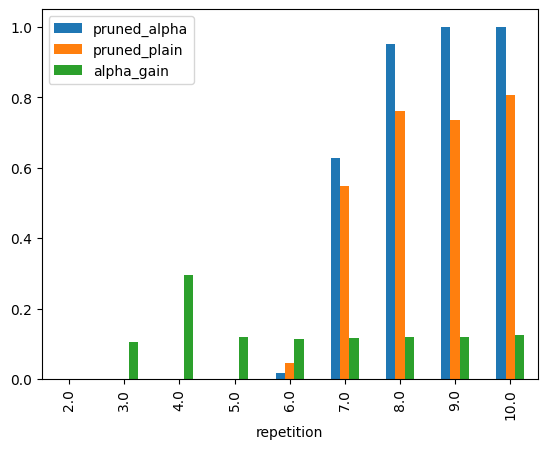

In [59]:
pdf_all['alpha_gain'] = ((pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0))
pdf_all["alpha_gain"] = pdf_all["alpha_gain"].astype(int)
pdf_all[["repetition", "pruned_alpha", "pruned_plain", "alpha_gain"]].groupby("repetition").mean().plot.bar()

#### prune vs repetition vs alpha-gain across iterations

In [ ]:
path = "/home/mzi/verif/alpha-beta-CROWN/complete_verifier/input_split/pickled/take_2_alpha_alternate_90_2_10_10_in19_lower04_upper06_eps001_out15_0_14/{}.pickle"

plain_prune_ratio_list = []
alpha_prune_ratio_list = []
alpha_gain_list = []
alpha_loss_list = []
repetition_avg_list = []

for i in range(1700):
    pdf = read_instance(path=path.format(i))[['pruned_plain', 'pruned_alpha', 'repetition']]
    
    plain_prune_ratio = pdf[(pdf['pruned_plain'] == 1)].size / pdf.size
    alpha_prune_ratio = pdf[(pdf['pruned_alpha'] == 1)].size / pdf.size
    alpha_gain = pdf[(pdf['pruned_alpha'] == 1) & (pdf['pruned_plain'] == 0)].size / pdf.size
    alpha_loss = pdf[(pdf['pruned_alpha'] == 0) & (pdf['pruned_plain'] == 1)].size / pdf.size
    
    plain_prune_ratio_list.append(plain_prune_ratio)
    alpha_prune_ratio_list.append(alpha_prune_ratio)
    alpha_gain_list.append(alpha_gain)
    alpha_loss_list.append(alpha_loss)
    repetition_avg_list.append(pdf.repetition.mean())


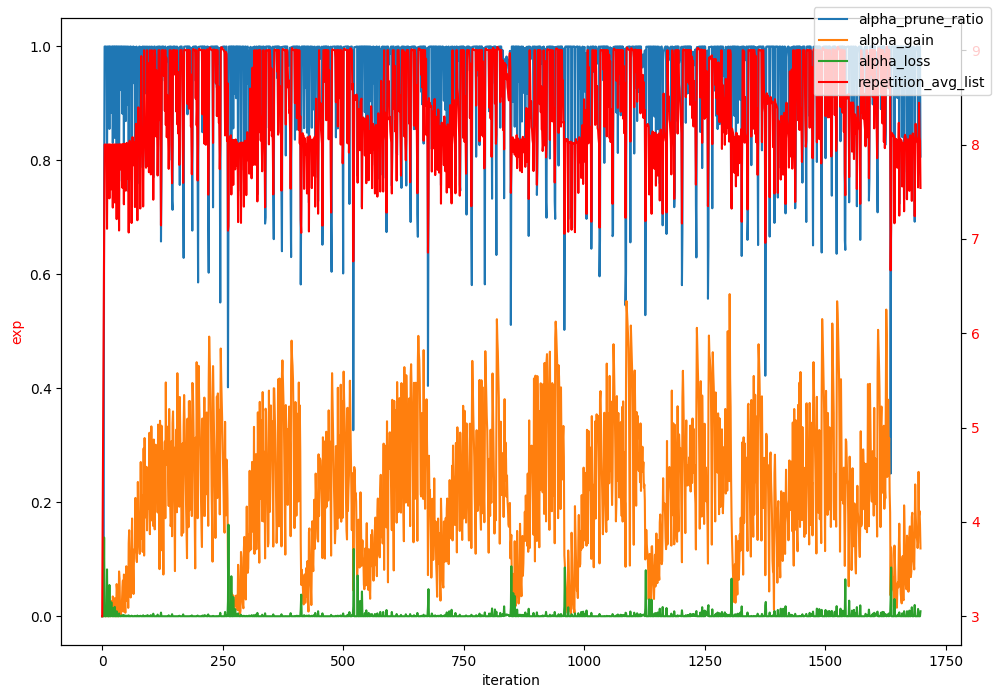

In [58]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.set_xlabel('iteration')
ax1.set_ylabel('exp', color="red")
ax1.plot(plain_prune_ratio_list, label="plain_prune_ratio", alpha=0.5)
ax1.plot(alpha_prune_ratio_list, label="alpha_prune_ratio")
ax1.plot(alpha_gain_list, label="alpha_gain")
ax1.plot(alpha_loss_list, label="alpha_loss")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(repetition_avg_list, color="red", label="repetition_avg_list")
ax2.tick_params(axis='y', labelcolor="red")

fig.tight_layout()
fig.legend()
plt.show()

### prune vs margin

In [3]:
pdf_all = read_instance(path=path.format(0))
pdf_all['iteration'] = 0

for i in range(1, 1700, 100):
    pdf = read_instance(path=path.format(i))
    pdf['iteration'] = i
    pdf_all = pd.concat([pdf, pdf_all])


#### find narrowest marigin idx

In [4]:
def find_top5(row):
    subset_columns = [f'output_margin_{i}' for i in range(28)]
    names = row[subset_columns].sort_values(ascending=False).head(5).index
    print(tuple([int(name.split("_")[-1]) for name in names]))
    return tuple([int(name.split("_")[-1]) for name in names])

pdf_all[['top_1', 'top_2', 'top_3', 'top_4', 'top_5']] = pdf_all.apply(find_top5, axis=1)


ValueError: Columns must be same length as key

In [1]:
!ls


pickled_analysis.ipynb
take_2_alpha_alternate_90_2_10_10_in19_lower04_upper06_eps001_out15_0_14


#### find positive margin idx

In [89]:
def locate_pos(row):
    for i in range(28):
        if row[f'output_margin_{i}'] > 0:
            return i
    
    return None

pdf_all['pos_prop'] = pdf_all.apply(locate_pos, axis=1)
pdf_pruned = pdf_all.dropna()

print(pdf_all.shape[0], pdf_all[['pos_prop']].isnull().shape[0] / pdf_all.shape[0], pdf_pruned.shape[0])

4587940 1.0 4417204


,output_margin_0,output_margin_1,output_margin_2,output_margin_3,output_margin_4,output_margin_5,output_margin_6,output_margin_7,output_margin_8,output_margin_9,...,diff_13,diff_14,diff_15,diff_16,diff_17,diff_18,repetition,pruned_plain,pruned_alpha,iteration
pos_prop,,,,,,,,,,,,,,,,,,,,,
8.0,34017,34017,34017,34017,34017,34017,34017,34017,34017,34017,...,34017,34017,34017,34017,34017,34017,34017,34017,34017,34017
9.0,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510,...,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510,2700510
11.0,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677,...,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677,1682677


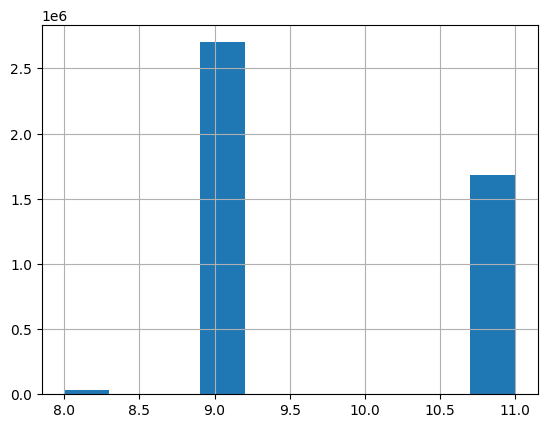

In [88]:
pdf_pruned['pos_prop'].hist()
pdf_pruned.groupby('pos_prop').count()